# SSD Trainig example.

In this notebook is the example of training procedure. Note, that it is tested only with `Tensorflow` backend and on my problem, so, **DON'T EXPECT THIS NOTEBOOK TO RUN** on your PC. It is provided only as example.

Moreover, here we see, that for my problem training data is obviously overfitted, but currently no augmentation is used. For ground truth input format, please, refer to `gt_pascal.pkl`.

In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread, imresize
import tensorflow as tf

from ssd import SSD
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# some constants
NUM_CLASSES = 1
CLASSES = [
    "person",
]
input_shape = (300, 300, 3)

In [3]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [4]:
gt = pickle.load(open('gt_pascal.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [5]:
batch_size = 8
#path_prefix = '../../frames/'

def generator(keys):
    while True:
        shuffle(keys)
        inputs = []
        targets = []
        for key in keys:            
            img_path = path_prefix + key
            img = image.load_img(img_path,
                                 target_size=(input_shape[0],
                                              input_shape[1]))
            img = image.img_to_array(img)
            inputs.append(img)
            y = bbox_util.assign_boxes(gt[key])
            targets.append(y)
            if len(targets) == batch_size:
                tmp_inp = np.array(inputs)
                tmp_targets = np.array(targets)
                inputs = []
                targets = []
                yield preprocess_input(tmp_inp), tmp_targets

In [6]:
import xml.etree.ElementTree as ET

batch_size = 8
path_prefix = '../../frames/'

def xml_tree_to_labels(tree):
    root = tree.getroot()
    size = root.find('size')
    width = float(size.find('width').text)
    height = float(size.find('height').text)
    label = []

    for obj in root.iter('object'):
        difficult = int(obj.find('difficult').text)
        cls_name = obj.find('name').text
        if cls_name not in CLASSES:
            continue
        cls_id = CLASSES.index(cls_name)
        xml_box = obj.find('bndbox')
        xmin = float(xml_box.find('xmin').text) / width
        ymin = float(xml_box.find('ymin').text) / height
        xmax = float(xml_box.find('xmax').text) / width
        ymax = float(xml_box.find('ymax').text) / height
        label.append([xmin, ymin, xmax, ymax] + [(1 if i == cls_id else 0) for i in range(len(CLASSES))])
        
    return np.array(label, dtype=np.float64)

def create_train_generators_from_voc_likedatasets(voc_dir="data/VOCdevkit/VOC2016/"):
    on_voc_dir = lambda x: os.path.join(voc_dir, x)
    def create_generator(id_dir):
        def _():
            while True:
                inputs = []
                targets = []
                image_ids = [l.strip() for l in open(id_dir)]
                shuffle(image_ids)
                for id in image_ids:
                    image_path = on_voc_dir("JPEGImages/{}.jpg".format(id))
                    img = image.load_img(image_path,
                        target_size=(input_shape[0],
                        input_shape[1])
                    )
                    img = image.img_to_array(img)
                    inputs.append(img)

                    gt = xml_tree_to_labels(ET.parse(on_voc_dir("Annotations/{}.xml".format(id))))

                    y = bbox_util.assign_boxes(gt)
                    target.append(y)
                    if len(targets) == batch_size:
                        tmp_inp = np.array(inputs)
                        tmp_targets = np.array(targets)
                        inputs = []
                        targets = []
                        yield preprocess_input(tmp_inp), tmp_targets
        return _
    return (
        create_generator(on_voc_dir("ImageSets/Main/trainval.txt")), 
        create_generator(on_voc_dir("ImageSets/Main/test.txt")),
    )

In [7]:
model = SSD(input_shape, num_classes=len(CLASSES))
#model.load_weights('weights_300x300.hdf5', by_name=True)

58834944/58889256 [============================>.] - ETA: 0s

AttributeError: 'MaxPooling2D' object has no attribute 'get_shape'

In [8]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [9]:
base_lr = 1e-3
optim = keras.optimizers.Adam(lr=base_lr, beta_1=0.5)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES).compute_loss)

In [11]:
nb_epoch = 30
history = model.fit_generator(generator(train_keys), num_train // batch_size,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=generator(val_keys),
                              nb_val_samples=num_val // batch_size,
                              nb_worker=1)

Epoch 1/30


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/training.py", line 425, in data_generator_task
    generator_output = next(generator)
  File "<ipython-input-5-6ce234c469c2>", line 13, in generator
    input_shape[1]))
  File "/usr/local/lib/python2.7/dist-packages/keras/preprocessing/image.py", line 173, in load_img
    img = Image.open(path)
  File "/usr/lib/python2.7/dist-packages/PIL/Image.py", line 1996, in open
    fp = builtins.open(fp, "rb")
IOError: [Errno 2] No such file or directory: u'../../frames/frame01648.png'



Exception: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None

In [16]:
inputs = []
images = []
img_path = path_prefix + train_keys[888]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [17]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s


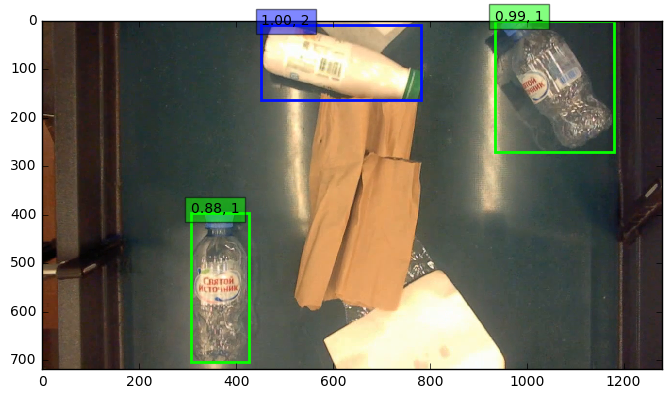

In [18]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()